# Create Prediction Forecast Endpointd
1. Load CSV 
2. Test Pickle
3. Create Prediction Function
4. Create Visualization Function
5. Test Prediction and Visualization Function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

/Users/jisha/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 1. Load CSV

In [2]:
population_melt = pd.read_csv('https://raw.githubusercontent.com/jiobu1/labspt15-cityspire-g-ds/main/notebooks/model/population2010-2019/csv/population_melt.csv')
population = pd.read_csv('https://raw.githubusercontent.com/jiobu1/labspt15-cityspire-g-ds/main/notebooks/model/population2010-2019/csv/population_cleaned.csv')

## 3. Create Prediction and Visualization Function

In [3]:
def population_forecast(city, periods):
    # Load Dataset
  population = pd.read_csv('https://raw.githubusercontent.com/jiobu1/labspt15-cityspire-g-ds/main/notebooks/model/population2010-2019/csv/population_cleaned.csv')
  population.reset_index(level=0, inplace=True)

  # Melt table into ds and y
  population_melt = population[['City,State', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
  population_melt = population_melt.melt(id_vars=['City,State'], var_name='ds', value_name='y')

  # Isolate city data
  city = [city]
  df_ = population_melt.loc[population_melt['City,State'].isin(city)][['ds', 'y']]
  df_.columns = ['ds','y']

  # Fit and Predict on city dataframe
  m = Prophet(interval_width=0.95)
  m.fit(df_)
  future = m.make_future_dataframe(periods=periods, freq='Y')
  forecast = m.predict(future)
  predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][10:]
  predictions['ds'] = pd.DatetimeIndex(predictions['ds']).year
  predictions[['yhat', 'yhat_lower', 'yhat_upper']] =  predictions[['yhat', 'yhat_lower', 'yhat_upper']].round()

  # Create graph
  # Graph first 10 years
  df_['ds'] = df_['ds'].astype(int)
  ax = df_.plot(x = 'ds', y = 'y', label='Observed', figsize= (10, 8)) 

  # Graph predictions including the upper and lower bounds
  predictions['ds'] = predictions['ds'].astype(int)
  predictions[['ds', 'yhat']].plot(ax = ax, x = 'ds', y = 'yhat', label = "Forecast") 
  ax.fill_between(predictions['ds'],
                predictions['yhat_lower'],
                predictions['yhat_upper'],
                color='k', 
                alpha=.25)

  ax.set_xlabel('Year')
  ax.set_ylabel('Population')
  plt.title(f"{city[0]} Population" )
  plt.legend()

  return predictions,   plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


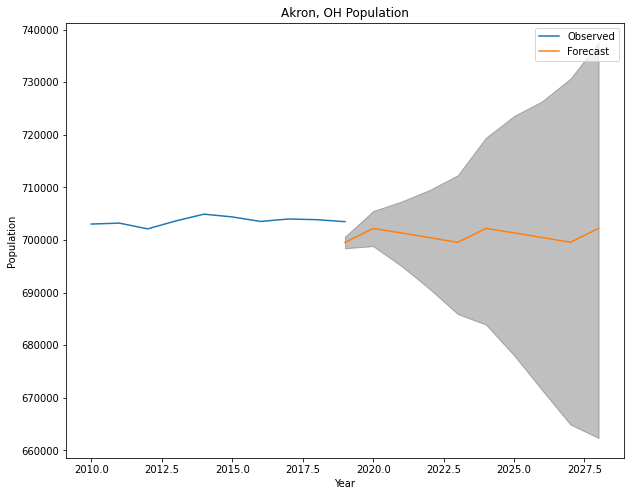

(      ds      yhat  yhat_lower  yhat_upper
 10  2019  699527.0    698417.0    700633.0
 11  2020  702177.0    698814.0    705498.0
 12  2021  701343.0    695059.0    707300.0
 13  2022  700448.0    690689.0    709507.0
 14  2023  699541.0    685912.0    712308.0
 15  2024  702190.0    683896.0    719440.0
 16  2025  701356.0    678048.0    723578.0
 17  2026  700462.0    671402.0    726394.0
 18  2027  699554.0    664888.0    730684.0
 19  2028  702204.0    662331.0    737517.0,
 None)

In [4]:
population_forecast('Akron, OH', 10)

## 4. Create Visualization Function
- no pred

In [5]:
POPULATION_CSV = 'https://raw.githubusercontent.com/jiobu1/labspt15-cityspire-g-ds/main/notebooks/model/population2010-2019/csv/population_cleaned.csv'
FORECAST_CSV = 'https://raw.githubusercontent.com/jiobu1/labspt15-cityspire-g-ds/main/notebooks/model/population2010-2019/csv/population_prediction.csv'

def get_plot(city):
  city = [city]

  # Historical population data
  population = pd.read_csv(POPULATION_CSV)
  population = population[population['City,State'].isin(city)]
  population = population[['City,State', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']]
  population_melt = population.melt(id_vars=['City,State'], var_name='ds', value_name='y')
  population_melt['ds'] = population_melt['ds'].astype(int)

  # Predictions
  forecast = pd.read_csv(FORECAST_CSV)
  df = forecast[forecast['City,State'].isin(city)][10:]
  df['year'] = df['year'].astype(int)

  # Graph Data
  ax = population_melt.plot(x = 'ds', y = 'y', label='Observed', figsize= (10, 8))
  df[['year', 'yhat']].plot(ax = ax, x = 'year', y = 'yhat', label = "Forecast")

  # Fill to show upper and lower bounds
  ax.fill_between(df['year'],
                df['yhat_lower'],
                df['yhat_upper'],
                color='k', 
                alpha=.25)

  ax.set_xlabel('Year')
  ax.set_ylabel('Population')
  plt.title(f"{city[0]} Population" )
  plt.legend()

  plt.show()

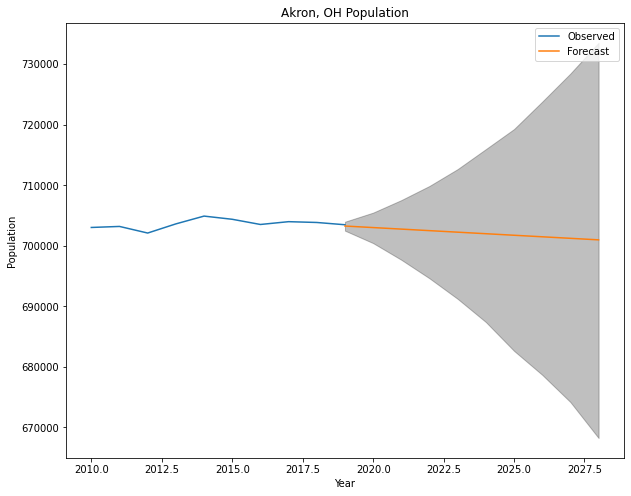

In [6]:
get_plot('Akron, OH')